In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import tqdm
import math
import xarray as xr
from scipy.special import softmax
import torch
%matplotlib inline
from torch.autograd import Variable


In [2]:
if torch.__version__ != '1.10.0':
    print('You need to upgrade PyTorch before running this code.')

else:
    print('Ready to go!')

Ready to go!


# Model definition 

In [381]:
class BinaryTS:
    
    def __init__(self,d=10,T=10,N=10, true_A=None, true_B=None, true_sigma=None,R=100000):
        
        """
        Instanciates the binaryTS model. 
        
        Arguments: 
        
        - d: dimension of the model. 
        - A: (d,d) matrix that controls the dynamics related to the observed state. 
        - B: (d,d) matrix that controls the dynamics related to the latent state. 
        - sigma: (d,d) positive definite matrix that controls the variance of the noise. 
        - R: number of MCMC samples for expectation approximations used in VEM. 
        
        By default, the BinaryTS model is instanciated with random matrices A, B and sigma. You can provide your 
        own, but B should have all its eigenvalues of module less than 1 in order to enforce stability of the model
        (see companion paper for further information). 
        
        """
        
        self.d = d
        self.T = T
        self.N = N
        
        if true_A is None:
            self.true_A = 0.8*np.identity(d) 
        else: 
            self.true_A = true_A
            
        if true_B is None:     
            random_eig = np.random.uniform(low=-0.7,high=0.7,size=d) 
            self.true_B = np.diag(random_eig) 
        else:
            self.true_B = true_B
        
        if true_sigma is None:
            random_matrix = np.random.randn(d,d)
            self.true_sigma = np.dot(random_matrix,random_matrix.T)
            
        else:
            self.true_sigma = true_sigma
        
        self.true_sigma_inv = np.linalg.inv(self.true_sigma)
        self.data = None
        self.R = R
        
        
        
    ### Util functions###
    
    def sample(self,N=100,T=100,fixdata=True):
        
        """
        Samples N samles over T timesteps from the DGP. If fixdata is set to True, sampled x data is saved in 
        an attribute called self.data, along with (N,T) used for sampling in self.N and self.T. 
        """
        
        x_data = np.zeros((N,self.d,T+1))
        z_data = np.zeros((N,self.d,T+1))
        p_data = np.zeros((N,self.d,T+1))
        
        self.x0 = np.random.randint(0,2,size=(self.d,N))
        self.z0 = np.random.randn(self.d,N)
        
        x = self.x0
        z = self.z0
        
        x_data[:,:,0] = self.x0.T
        z_data[:,:,0] = self.z0.T
        p_data[:,:,0] = 1/2*np.ones((N,self.d))
        
        for t in np.arange(1,T+1): 
            z = self.true_A@x + self.true_B@z + np.random.multivariate_normal(mean=np.zeros(self.d),cov=self.true_sigma,size=N).T
            p = softmax(z,axis=0)
            x = np.random.binomial(1,p,size=(self.d,N))
            x_data[:,:,t] = x.T
            z_data[:,:,t] = z.T
            p_data[:,:,t] = p.T
            
        if fixdata: 
            self.data = x_data
            self.N = N
            self.T = T
        
        return x_data,z_data,p_data
    
    def snapshot(self,N,T,x_data=None,z_data=None,p_data=None,pltdim = 3,plttime=500,save=False): 
        
        """
        Generates and plots some data from the data generating process. This method displayes three components 
        of the DGP for every dimension: 
        - the observed, 0-1 valued process
        - the latent state
        - the probability associated to the current latent state obtained through softmaxification. 
        
        Arguments:
        
        - N: number of individuals (for plotting, one is choosen at random).
        - T: number of timesteps over which data is generated. 
        - x_data, z_data, p_data: allows to pass previously generate data for plotting (instead of 
        generating new observations).
        - pltdim: number of dimensions plotted. 
        - plttime: number of timesteps plotted. 
        - save: if set to True, a .pdf of the generated image is saved. 
        """
        
        if x_data is None and z_data is None and p_data is None: 
            x_data,z_data,p_data = self.sample(N=N,T=T,fixdata=False)
            
        plttime = np.minimum(T,plttime)
        pltdim = np.minimum(pltdim,self.d)
        random_ind = np.random.randint(0,N)
        
        sns.set_context('talk')
        sns.set_style('white')
            
        f,ax=plt.subplots(pltdim,3,figsize=(pltdim*30,pltdim*13))
        f.suptitle('Observed state, hidden state and transition probability by dimension of the model',fontsize=65,fontweight='heavy')
                
        for i in np.arange(pltdim):
        
            ax[i,0].plot(x_data[random_ind,i,:plttime],c='orange')
            ax[i,1].plot(z_data[random_ind,i,:plttime],c='red')
            ax[i,2].plot(p_data[random_ind,i,:plttime],c='green')
            
                        
            ax[i,0].set_yticks([0,1])
            
            for a in ['left','bottom']:
            
                ax[i,0].spines[a].set_linewidth(2.5)
                ax[i,1].spines[a].set_linewidth(2.5)
                ax[i,2].spines[a].set_linewidth(2.5)
            
            for j in [0,1,2]:
                ax[i,j].spines["right"].set_visible(False)
                ax[i,j].spines["top"].set_visible(False)
                ax[i,j].tick_params(axis='both', labelsize=50)
        
        
        ax[pltdim-1,0].set_xlabel('Observed state',fontsize=55,fontweight='bold',labelpad=20)
        ax[pltdim-1,1].set_xlabel('Hidden state',fontsize=55,fontweight='bold',labelpad=20)
        ax[pltdim-1,2].set_xlabel('Transition probability',fontsize=55,fontweight='bold',labelpad=20)
        
        plt.tight_layout()
        
        if save: 
            
            plt.savefig('snapshot.pdf')
    
    
    ### Functions for VEM ###
    
    def variance_initialization(self): 
        
        """
        Returns a random initialization for the diagonal and subdiagonal elements of the B matrix that
        parametrizes the variational density, as a (self.d,2*self.T+1)-tensor. For every line d, the first
        self.T+1 elements are the diagonal elements of the Cholesky decomposition of the precision matrix
        of dimension d, while the next self.T elements are the subdiagonal elements. 
        
        The precision matrices (there are d of them) can be obtained by calling 
        self.compute_precision(self.form_B(self.variance_initialization())).
        
        """
        
        return torch.rand(self.d,2*self.T+1)
    
    def form_B(self,nu_omega): 
        
        """
        Given a (d,2*T+1)-tensor as input, forms a (d,T+1,T+1)-tensor structured as follows: 
            - for a given d, the diagonal elements of the (T+1,T+1) subtensor are the first T+1 elements 
            of nu_omega[d,:].
            - for a given d, the subdiagonal elements of the (T+1,T+1) subtensor are the last T elements of 
            nu_omega[d,:].
        """
        
        nu = nu_omega[:,:self.T+1]
        omega = nu_omega[:,self.T+1:]
        
        B=torch.diag_embed(nu)+torch.diag_embed(omega,offset=1)
        
        return B

    
    def compute_precision(self,B): 
        
        """
        Given a (d,self.T+1,self.T+1)-tensor of Cholesky decompositions that parametrizes the 
        variational density, returns the un-decomposed matrix.   
        
        Arguments:
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.
        """
        
        return torch.transpose(B,dim0=1,dim1=2)@B
    
    def compute_covmat(self,B): 
        
        """
        Computes the (self.d,self.T+1,self.T+1)-variance-covariance tensor, starting from 
        a (self.d,self.T+1,self.T+1)-Cholesky decomposition-tensor, in a differentiable way.
        
        Arguments: 
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.   
        """
        
        return torch.linalg.inv(torch.transpose(B,dim0=1,dim1=2)@B)
    
    def check_data(self):
        
        """
        Util function to check wether self.data is empty.
        """
        
        if self.data is None: 
            raise ValueError('self.data is empty. Use self.sample(args,fixdata=True) to sample some data first.')
            
    def full_log_expectation(self): 
    
        """
        For every t in [1,self.T], approximates the expectation of 
        
                        $\log \sum_p \exp[\Omega_p^{(t,t)}X+\mu_{p,t}]$
                        
        through MCMC-approximation with self.R samples, where 
            - Omega_i^{(t,t)} is the (t,t)-th element of the variance-covariance matrix of the d-th dimension 
            of the variational density.
            - mu_{p,t} is the (p,t)-th element of the expectation matrix of the variational density. 
            
        Returns a (self.T+1)-tensor. 

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
    
        sigma_inv = torch.linalg.inv(self.sigma)

        precision_matrix = self.compute_precision(self.form_B(self.var_approx))
        covariance_matrix = self.compute_covmat(precision_matrix[:,1:,1:])
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        draw = torch.randn(self.R,self.d,self.T)
        transformed_draw = diagonal_terms*draw + self.mu_approx[:,1:]
        logsumexp_draw = torch.logsumexp(transformed_draw,dim=1)
        vector_approx = logsumexp_draw.mean()
        sum_approx = vector_approx.sum()
        
        return sum_approx 
    
    def partial_log_expectation(self):
    
        """
        For every i in [1,self.d] and every t in [0,self.T], approximates the expectation of 
        
                        $\log \sum_{p \neq i} \exp[\Omega_{p}^{(t,t)}X+\mu_{p,t}]$
                        
        through MCMC-approximation with self.R samples, where 
            - Omega_i^{(t,t)} is the (t,t)-th element of the variance-covariance matrix of the d-th dimension 
            of the variational density.
            - mu_{p,t} is the (p,t)-th element of the expectation matrix of the variational density. 
            
        Returns a (self.d,self.T+1)-tensor. 

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R

        sigma_inv = torch.linalg.inv(self.sigma)
        
        precision_matrix = self.compute_precision(self.form_B(self.var_approx))
        covariance_matrix = self.compute_covmat(precision_matrix[:,1:,1:])
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        results = torch.zeros(self.d,self.T)
        
        for i in np.arange(d): 
            
            draw = torch.randn(self.R,self.d,self.T)
            mask = torch.ones(d)
            mask[i] = 0
            mask = mask.long()
            masked_diagonal_terms = diagonal_terms[mask,:]
            masked_mu_approx = self.mu_approx[mask,1:]
            transformed_draw = masked_diagonal_terms*draw + masked_mu_approx
            logsumexp_draw = torch.logsumexp(transformed_draw,dim=1)
            vector_approx = logsumexp_draw.mean()
            results[i,:] = vector_approx

        return results
    
    def compute_bilinear_term(self):
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
       
        sigma_inv = torch.linalg.inv(self.sigma)
        
        
        data = torch.from_numpy(self.data).type(torch.FloatTensor)
                        
        result = -N/2*torch.trace(self.mu_approx[:,1:].T@sigma_inv@self.mu_approx[:,1:])
        
        result += N*torch.trace(self.mu_approx[:,1:].T@sigma_inv@self.B@self.mu_approx[:,:T])
        
        result += -N/2*torch.trace(self.mu_approx[:,:T].T@(self.B.T)@sigma_inv@self.B@self.mu_approx[:,:T])
        
        result += -1/2*sum([torch.trace((self.A@data[i,:,:T]).T@sigma_inv@(self.A@data[i,:,:T])) for i in np.arange(N)])
                
        result += -sum([torch.trace((self.A@data[i,:,:T]).T@sigma_inv@(self.B@self.mu_approx[:,:T]-self.mu_approx[:,1:])) for i in np.arange(N)])
        
        return result   
        
    def compute_elbo(self):
        
        """
        Returns the Evidence Lower Bound (ELBO) of the model, normalized by 1/(N*T*d), as a pytorch tensor.
        """
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
                
        sigma_inv = torch.linalg.inv(self.sigma)
        data = torch.from_numpy(self.data).type(torch.FloatTensor)
        var_approx = self.form_B(self.var_approx)
        covariance_matrix = self.compute_covmat(var_approx)
        
        variational_entropy = 2*N*sum([sum(torch.log(torch.diag(var_approx[i,:,:]))) for i in np.arange(d)])

        entropy = -(T*N/2)*torch.logdet(self.sigma)
        
        #Compute bilinear term
        
        bilinear_term = self.compute_bilinear_term()
        
        #Compute big sum with approximated expectations
        
        mu_x_prod = sum([torch.trace(data[i,:,1:].T@self.mu_approx[:,1:]) for i in np.arange(N)])
        
        full_log_approx = self.full_log_expectation()
        
        big_sum = mu_x_prod + N*d*full_log_approx
                
        partial_log_approx = self.partial_log_expectation()
        
        big_sum += -(data[:,:,1:]*partial_log_approx).sum() + N*(partial_log_approx.sum())
        
        #Compute trace term
        
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        sub_diagonal_terms = torch.diagonal(covariance_matrix,offset=1,dim1=1,dim2=2)
        
        trace_term = (torch.diagonal(sigma_inv)*(diagonal_terms[:,1:].sum(axis=1))).sum()
        
        trace_term += (torch.diagonal(self.B.T@sigma_inv@self.B)*(diagonal_terms[:,:T].sum(axis=1))).sum()
        
        trace_term += -(torch.diagonal(sigma_inv@self.B)*(sub_diagonal_terms.sum(axis=1))).sum()
        
        trace_term = -1/2*trace_term 
        
        #Put all terms together
        
        elbo_value = variational_entropy + entropy + bilinear_term + big_sum + trace_term 

        return (1/(N*T*d))*elbo_value
    
    #Optimization methods
    
    def define_tracks(self):
        
        """
        Util function that defines empty tensors for saving training results. 
        
        """
        
        self.elbo_track = torch.zeros(1)
        
        self.mu_approx_track = torch.zeros(self.d,self.T+1)
        self.var_approx_track = torch.zeros(self.d,self.T+1,self.T+1)
        
        self.A_track = torch.zeros(self.d,self.d)
        self.A_error_track = torch.zeros(1)
        
        self.B_track = torch.zeros(self.d,self.d)
        self.B_error_track = torch.zeros(1)
        
        self.sigma_track = torch.zeros(self.d,self.d)
        self.sigma_error_track = torch.zeros(1)
    
    def save_results(self): 
        
        """
        Util function that saves current values of
            - the ELBO (Evidence Lower Bound), which is the objective function that is maximized ;
            - mu_approx, a (d,T+1)-tensor that encodes the variational mean parameters ;
            - var_approx, a (d,T+1,T+1)-tensor that encodes the variational variance parameters ;
        
        and the current estimated values of 
            - A, B and sigma, three (d,d)-tensors that govern the dynamics of the latent space. 
            
        This function also saves the difference in Froebenius norm between these estimates and the 
        real parameters of the model. 
        
        Before calling this function, you need to define 
            - self.elbo_track
            - self.mu_approx_track
            - self.var_approx_track
            - self.A_track
            - self.A_error_track
            - self.B_track
            - self.B_error_track
            - self.sigma_track
            - self.sigma_error_track
            
        as empty tensors. This can be done by calling the util function self.define_tracks() 
        
        torch.no_grad() is called to speed up code. 
        
        """
        
        with torch.no_grad():
            
            #Save ELBO
            
            self.elbo_track = torch.cat((self.elbo_track,torch.tensor([-self.elbo])))
            
            #Save mu_approx results
            
            self.mu_approx_track = torch.cat((self.mu_approx_track,self.mu_approx))
            
            #Save var_approx results
            
            cholesky_dec = self.form_B(self.var_approx)
            precision_matrix = self.compute_precision(cholesky_dec)
            self.var_approx_track = torch.cat((self.var_approx_track,precision_matrix))
            
            #Save A results
            
            self.A_track = torch.cat((self.A_track,self.A))
            A_error = torch.tensor([torch.norm(torch.tensor(self.true_A)-self.A)])
            self.A_error_track = torch.cat((self.A_error_track,A_error))
            
            #Save B results
            
            self.B_track = torch.cat((self.B_track,self.B))
            B_error = torch.tensor([torch.norm(torch.tensor(self.true_B)-self.B)])
            self.B_error_track = torch.cat((self.B_error_track,B_error))
            
            #Save sigma results
            
            self.sigma_track = torch.cat((self.sigma_track,self.sigma))
            sigma_error = torch.tensor([torch.norm(torch.tensor(self.true_sigma)-self.sigma)])
            self.sigma_error_track = torch.cat((self.sigma_error_track,sigma_error))
    
    def v_step(self,max_iter=500,lr=1e-5,verbose=True):
        
        """
        Solves the optimization problem
        
                                \max_{mu_approx,var_approx} ELBO(A,B,sigma,mu_approx,var_approx)
                                
        by gradient descent. 
        
        """
        
        if self.mu_approx is None:
            data_mean = self.data.mean(axis=0)
            mu_approx = torch.from_numpy(data_mean)
            mu_approx = mu_approx.float()
            mu_approx.requires_grad=True
            self.mu_approx = mu_approx
            
        if self.var_approx is None:
            var_approx = self.variance_initialization()
            var_approx.requires_grad = True  
            self.var_approx = var_approx
        
        optimizer = torch.optim.SGD([self.mu_approx,self.var_approx], lr=lr)
        
        for t in range(max_iter):
            
            optimizer.zero_grad()

            self.elbo = -self.compute_elbo()

            self.elbo.backward(retain_graph=True)
    
            optimizer.step()
        
            if t%10 == 0 and verbose: 
                
                print('V-step ELBO:', self.elbo)

                
    def em_step(self,max_iter=500,lr=0.005,verbose=True): 
        
        """
        Solves the optimization problem
        
                                \max_{A,B,sigma} ELBO(A,B,sigma,mu_approx,var_approx)
                                
        by gradient descent. 
        
        """
                
        optimizer = torch.optim.SGD([self.A,self.B,self.sigma], lr=lr)
        
        for t in range(max_iter):
            
            optimizer.zero_grad()

            self.elbo = - self.compute_elbo()

            self.elbo.backward(retain_graph=True)
    
            optimizer.step()
                
            if t%10 == 0 and verbose: 
                
                print('EM-step ELBO:', self.elbo)
        

    def optimize(self,max_iter=100,lr1=1e-3,lr2=1e-6,verbose=True):
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        it=10
        
        self.sample(N=N,T=T)
        
        #Parameters initialization
        
        sigma = torch.eye(d,d)
        sigma.requires_grad=True
        self.sigma = sigma
        self.sigma_inv = torch.linalg.inv(sigma)
        
        A = torch.eye(d,d) + torch.randn(d,d)
        A.requires_grad = True
        self.A = A
        
        B = torch.eye(d,d)
        B.requires_grad = True
        self.B = B
        
        data_mean = self.data.mean(axis=0)
        mu_approx = torch.from_numpy(data_mean)
        mu_approx = mu_approx.float()
        mu_approx.requires_grad=True
        self.mu_approx = mu_approx
        
        var_approx = self.variance_initialization()
        var_approx.requires_grad = True
        self.var_approx = var_approx
        
        self.define_tracks()
        
        for t in np.arange(max_iter):
            
            print('------ Iteration ', t,' ------   ')
            self.v_step(max_iter=it,lr=lr1,verbose=verbose)
            self.em_step(max_iter=it,lr=lr2,verbose=verbose)
            self.save_results()
            
            
    def full_optimization(self,lr=1e-10,max_iter=200,):
        
        """
        Solves the optimization problem
        
                                \max_{A,B,mu_approx,var_approx} ELBO(A,B,sigma,mu_approx,var_approx)
                                
        by gradient descent. 
        
        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        self.sample(N=N,T=T)
        
        #Parameters initialization
        
        sigma = 2*torch.eye(self.d,self.d)
        sigma.requires_grad=True
        self.sigma = sigma
        
        A = torch.ones(self.d,self.d)
        A.requires_grad = True
        self.A = A
        
        B = torch.randn(self.d,self.d)
        B = B.T@B
        B.requires_grad = True
        self.B = B
        
        data_mean = self.data.mean(axis=0)
        mu_approx = torch.from_numpy(data_mean)
        mu_approx = mu_approx.float()
        mu_approx.requires_grad=True
        self.mu_approx = mu_approx
        
        var_approx = self.variance_initialization()
        var_approx.requires_grad = True
        self.var_approx = var_approx
            
        self.define_tracks()
        
        optimizer = torch.optim.SGD([
                                        {'params': self.A, 'lr':1e-2}, 
                                        {'params': self.B, 'lr':1e-2}, 
                                        {'params': self.sigma, 'lr':1e-2},
                                        {'params': self.mu_approx,'lr':3e-5},
                                        {'params': self.var_approx, 'lr':3e-5}])
        
        for t in range(max_iter):

            self.elbo = - self.compute_elbo()
            
            if math.isnan(self.elbo):
                print('ELBO is NaN.')
                print(self.A)
                print(self.B)
                print(self.sigma)

            self.elbo.backward()
    
            optimizer.step()
        
            optimizer.zero_grad()
        
            self.save_results()
                
            if t%10 == 0: 
                
                print('------ Iteration ', t,' ------   ')
                print('ELBO:', self.elbo)            

# Optimization tests

In [382]:
d = 2
T = 2
N = 200

In [383]:
true_A = 0.7*np.identity(d) + 0.1*np.random.randn(d,d)
true_B = np.diag(np.random.uniform(low=-0.8,high=0.8,size=d))

random_matrix = np.random.randn(d,d)
true_sigma = 1/5*np.dot(random_matrix,random_matrix.T)

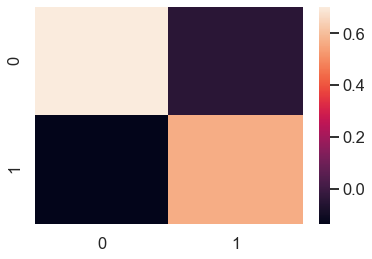

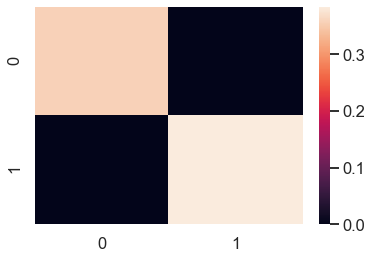

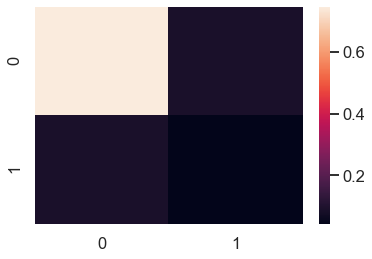

In [384]:
sns.heatmap(true_A)
plt.show()
sns.heatmap(true_B)
plt.show()
sns.heatmap(true_sigma)
plt.show()

In [385]:
bints = BinaryTS(d=d,T=T,N=N,true_A = true_A,true_B=true_B,true_sigma = true_sigma)

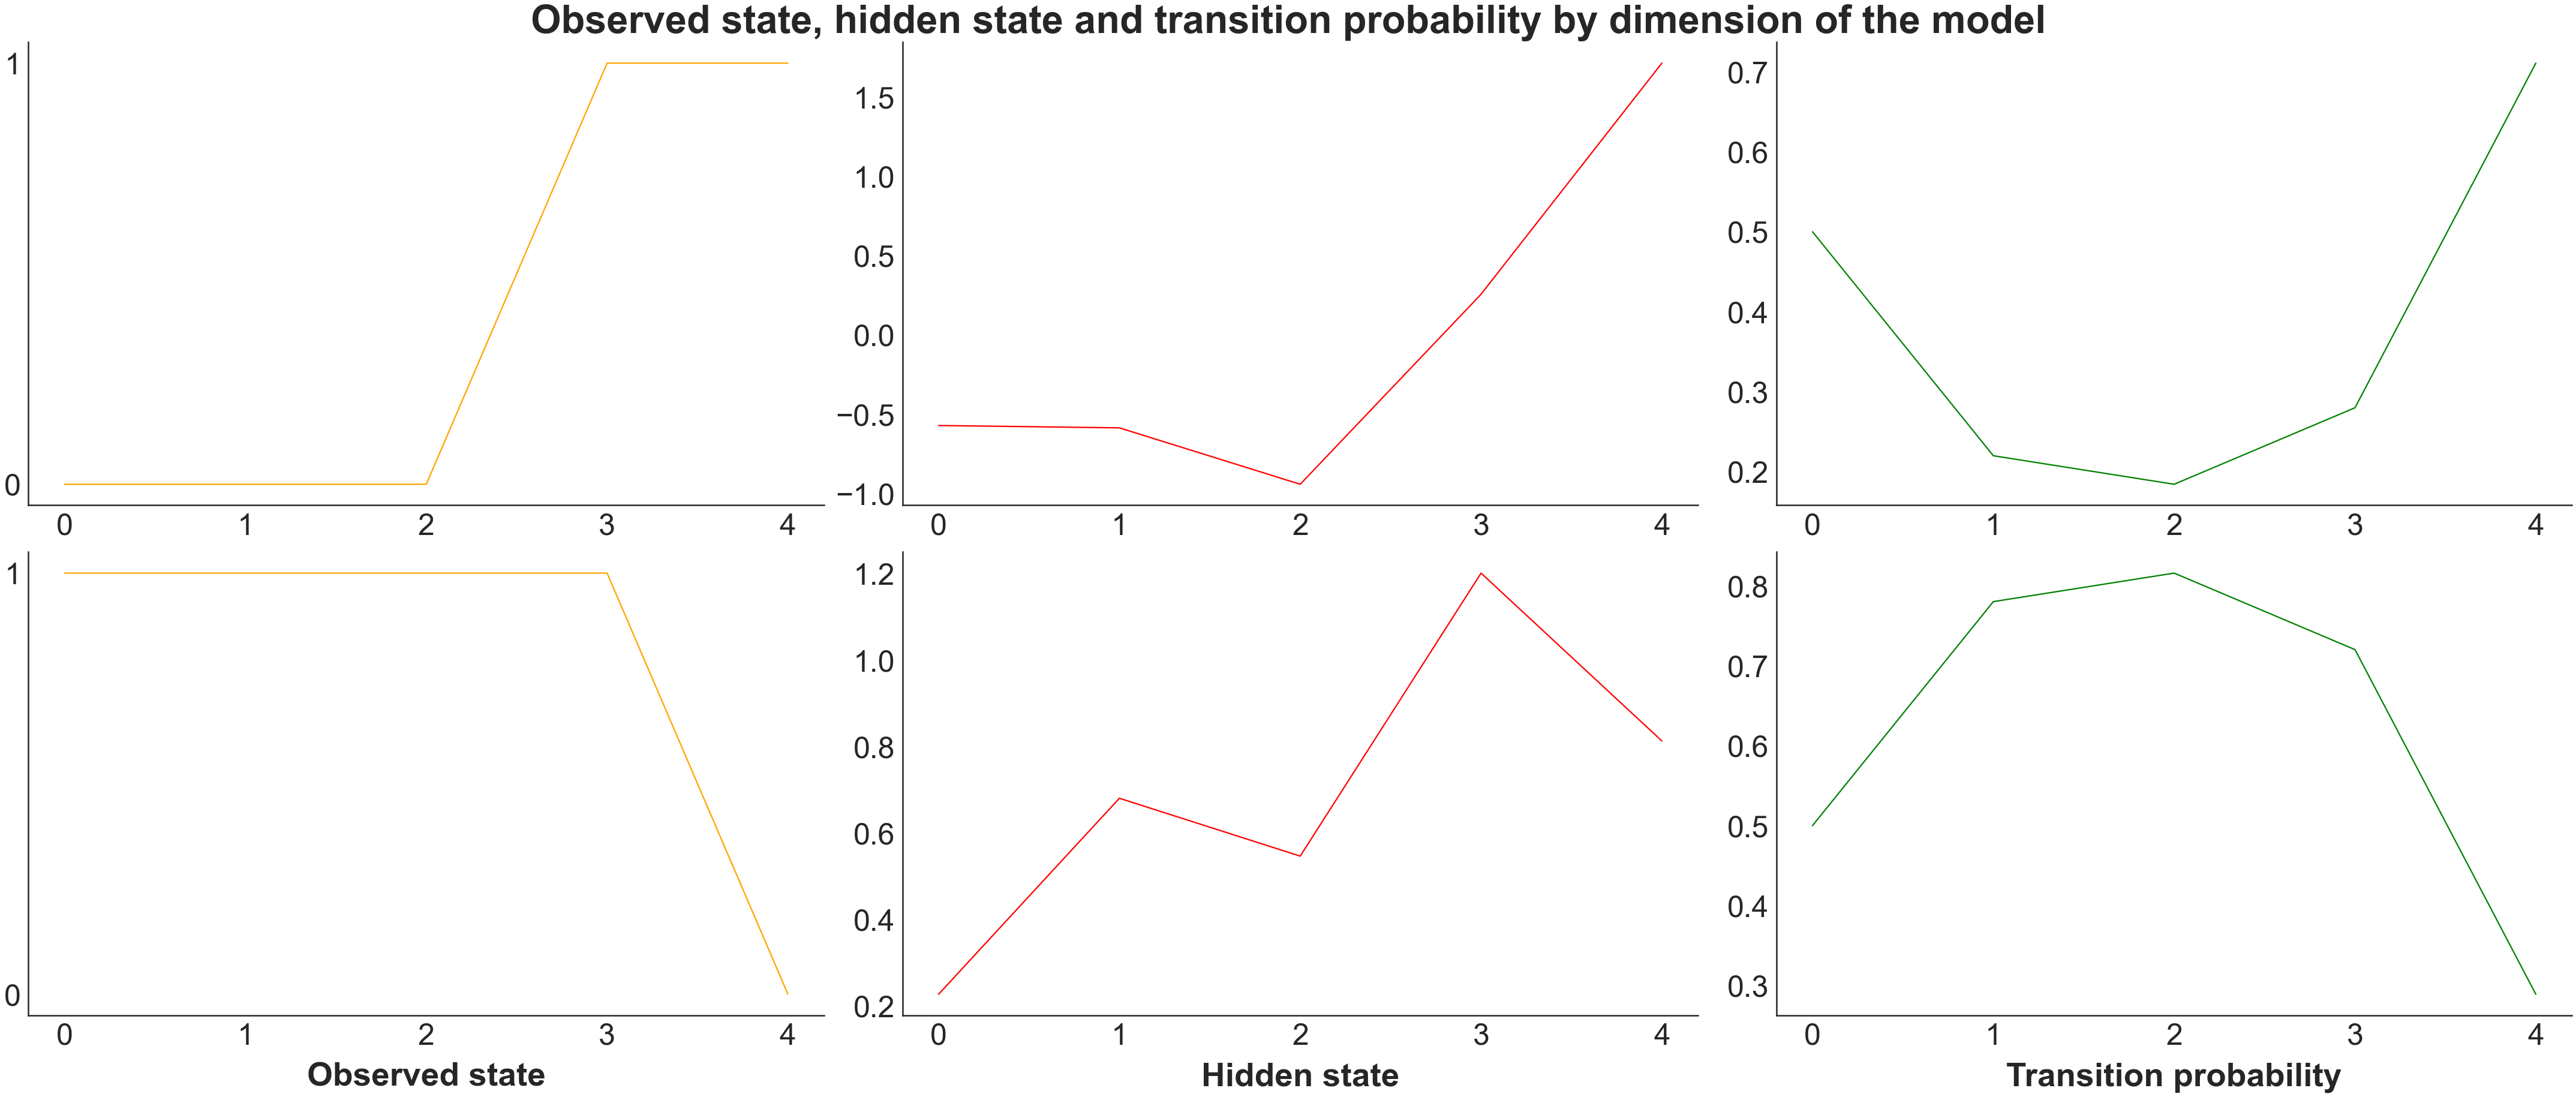

In [386]:
bints.snapshot(N=2,T=5)

## Full optimization

In [345]:
bints.full_optimization(max_iter=2200,lr=5e-2)

------ Iteration  0  ------   
ELBO: tensor(0.9671, grad_fn=<NegBackward0>)
------ Iteration  10  ------   
ELBO: tensor(0.0053, grad_fn=<NegBackward0>)
------ Iteration  20  ------   
ELBO: tensor(-0.3027, grad_fn=<NegBackward0>)
------ Iteration  30  ------   
ELBO: tensor(-0.5163, grad_fn=<NegBackward0>)
------ Iteration  40  ------   
ELBO: tensor(-0.6515, grad_fn=<NegBackward0>)
------ Iteration  50  ------   
ELBO: tensor(-0.7843, grad_fn=<NegBackward0>)
------ Iteration  60  ------   
ELBO: tensor(-0.8711, grad_fn=<NegBackward0>)
------ Iteration  70  ------   
ELBO: tensor(-0.9634, grad_fn=<NegBackward0>)
------ Iteration  80  ------   
ELBO: tensor(-1.0465, grad_fn=<NegBackward0>)
------ Iteration  90  ------   
ELBO: tensor(-1.1360, grad_fn=<NegBackward0>)
------ Iteration  100  ------   
ELBO: tensor(-1.2032, grad_fn=<NegBackward0>)
------ Iteration  110  ------   
ELBO: tensor(-1.2967, grad_fn=<NegBackward0>)
------ Iteration  120  ------   
ELBO: tensor(-1.3588, grad_fn=<N

------ Iteration  1040  ------   
ELBO: tensor(-0.9558, grad_fn=<NegBackward0>)
------ Iteration  1050  ------   
ELBO: tensor(-0.9680, grad_fn=<NegBackward0>)
------ Iteration  1060  ------   
ELBO: tensor(-0.9742, grad_fn=<NegBackward0>)
------ Iteration  1070  ------   
ELBO: tensor(-0.9827, grad_fn=<NegBackward0>)
------ Iteration  1080  ------   
ELBO: tensor(-0.9949, grad_fn=<NegBackward0>)
------ Iteration  1090  ------   
ELBO: tensor(-1.0027, grad_fn=<NegBackward0>)
------ Iteration  1100  ------   
ELBO: tensor(-1.0110, grad_fn=<NegBackward0>)
------ Iteration  1110  ------   
ELBO: tensor(-1.0168, grad_fn=<NegBackward0>)
------ Iteration  1120  ------   
ELBO: tensor(-1.0283, grad_fn=<NegBackward0>)
------ Iteration  1130  ------   
ELBO: tensor(-1.0394, grad_fn=<NegBackward0>)
------ Iteration  1140  ------   
ELBO: tensor(-1.0458, grad_fn=<NegBackward0>)
------ Iteration  1150  ------   
ELBO: tensor(-1.0597, grad_fn=<NegBackward0>)
------ Iteration  1160  ------   
ELBO: 

ELBO is NaN.
tensor([[-1.0245, -1.0583],
        [ 2.2440,  2.2907]], requires_grad=True)
tensor([[ 1.4349,  1.3610],
        [-2.1944, -0.2799]], requires_grad=True)
tensor([[  4.9060,   9.3131],
        [-11.3730, -29.8549]], requires_grad=True)
ELBO is NaN.
tensor([[-1.0222, -1.0559],
        [ 2.2450,  2.2917]], requires_grad=True)
tensor([[ 1.4363,  1.3610],
        [-2.1932, -0.2786]], requires_grad=True)
tensor([[  4.9064,   9.3130],
        [-11.3728, -29.8548]], requires_grad=True)
ELBO is NaN.
tensor([[-1.0198, -1.0535],
        [ 2.2460,  2.2927]], requires_grad=True)
tensor([[ 1.4377,  1.3609],
        [-2.1921, -0.2773]], requires_grad=True)
tensor([[  4.9068,   9.3130],
        [-11.3726, -29.8548]], requires_grad=True)
ELBO is NaN.
tensor([[-1.0175, -1.0511],
        [ 2.2470,  2.2938]], requires_grad=True)
tensor([[ 1.4390,  1.3608],
        [-2.1909, -0.2760]], requires_grad=True)
tensor([[  4.9071,   9.3129],
        [-11.3724, -29.8547]], requires_grad=True)
ELBO is 

ELBO is NaN.
tensor([[-0.9495, -0.9808],
        [ 2.2788,  2.3265]], requires_grad=True)
tensor([[ 1.4796,  1.3570],
        [-2.1557, -0.2367]], requires_grad=True)
tensor([[  4.9112,   9.3140],
        [-11.3691, -29.8524]], requires_grad=True)
------ Iteration  1560  ------   
ELBO: tensor(nan, grad_fn=<NegBackward0>)
ELBO is NaN.
tensor([[-0.9475, -0.9786],
        [ 2.2799,  2.3276]], requires_grad=True)
tensor([[ 1.4808,  1.3569],
        [-2.1546, -0.2355]], requires_grad=True)
tensor([[  4.9111,   9.3141],
        [-11.3691, -29.8522]], requires_grad=True)
ELBO is NaN.
tensor([[-0.9454, -0.9765],
        [ 2.2809,  2.3286]], requires_grad=True)
tensor([[ 1.4821,  1.3567],
        [-2.1534, -0.2342]], requires_grad=True)
tensor([[  4.9110,   9.3142],
        [-11.3690, -29.8521]], requires_grad=True)
ELBO is NaN.
tensor([[-0.9433, -0.9744],
        [ 2.2820,  2.3297]], requires_grad=True)
tensor([[ 1.4833,  1.3565],
        [-2.1523, -0.2330]], requires_grad=True)
tensor([[  4.

ELBO is NaN.
tensor([[-0.8846, -0.9137],
        [ 2.3143,  2.3629]], requires_grad=True)
tensor([[ 1.5185,  1.3507],
        [-2.1186, -0.1952]], requires_grad=True)
tensor([[  4.9029,   9.3202],
        [-11.3703, -29.8479]], requires_grad=True)
ELBO is NaN.
tensor([[-0.8828, -0.9118],
        [ 2.3154,  2.3641]], requires_grad=True)
tensor([[ 1.5196,  1.3505],
        [-2.1175, -0.1939]], requires_grad=True)
tensor([[  4.9025,   9.3205],
        [-11.3704, -29.8477]], requires_grad=True)
ELBO is NaN.
tensor([[-0.8809, -0.9098],
        [ 2.3165,  2.3652]], requires_grad=True)
tensor([[ 1.5207,  1.3503],
        [-2.1163, -0.1926]], requires_grad=True)
tensor([[  4.9020,   9.3208],
        [-11.3705, -29.8476]], requires_grad=True)
ELBO is NaN.
tensor([[-0.8791, -0.9079],
        [ 2.3176,  2.3663]], requires_grad=True)
tensor([[ 1.5219,  1.3500],
        [-2.1152, -0.1914]], requires_grad=True)
tensor([[  4.9016,   9.3210],
        [-11.3706, -29.8474]], requires_grad=True)
ELBO is 

ELBO is NaN.
tensor([[-0.8243, -0.8513],
        [ 2.3529,  2.4026]], requires_grad=True)
tensor([[ 1.5551,  1.3422],
        [-2.0802, -0.1519]], requires_grad=True)
tensor([[  4.8826,   9.3316],
        [-11.3760, -29.8414]], requires_grad=True)
ELBO is NaN.
tensor([[-0.8226, -0.8496],
        [ 2.3540,  2.4038]], requires_grad=True)
tensor([[ 1.5561,  1.3420],
        [-2.0791, -0.1507]], requires_grad=True)
tensor([[  4.8818,   9.3320],
        [-11.3763, -29.8412]], requires_grad=True)
ELBO is NaN.
tensor([[-0.8209, -0.8478],
        [ 2.3552,  2.4050]], requires_grad=True)
tensor([[ 1.5571,  1.3417],
        [-2.0779, -0.1494]], requires_grad=True)
tensor([[  4.8810,   9.3324],
        [-11.3765, -29.8410]], requires_grad=True)
ELBO is NaN.
tensor([[-0.8192, -0.8461],
        [ 2.3564,  2.4062]], requires_grad=True)
tensor([[ 1.5582,  1.3414],
        [-2.0768, -0.1481]], requires_grad=True)
tensor([[  4.8803,   9.3328],
        [-11.3768, -29.8407]], requires_grad=True)
------ I

ELBO is NaN.
tensor([[-0.7710, -0.7962],
        [ 2.3927,  2.4436]], requires_grad=True)
tensor([[ 1.5881,  1.3325],
        [-2.0423, -0.1090]], requires_grad=True)
tensor([[  4.8520,   9.3472],
        [-11.3859, -29.8333]], requires_grad=True)
------ Iteration  1660  ------   
ELBO: tensor(nan, grad_fn=<NegBackward0>)
ELBO is NaN.
tensor([[-0.7694, -0.7946],
        [ 2.3940,  2.4449]], requires_grad=True)
tensor([[ 1.5890,  1.3322],
        [-2.0411, -0.1077]], requires_grad=True)
tensor([[  4.8509,   9.3477],
        [-11.3862, -29.8330]], requires_grad=True)
ELBO is NaN.
tensor([[-0.7679, -0.7930],
        [ 2.3952,  2.4462]], requires_grad=True)
tensor([[ 1.5900,  1.3319],
        [-2.0399, -0.1064]], requires_grad=True)
tensor([[  4.8498,   9.3483],
        [-11.3866, -29.8328]], requires_grad=True)
ELBO is NaN.
tensor([[-0.7663, -0.7914],
        [ 2.3965,  2.4475]], requires_grad=True)
tensor([[ 1.5910,  1.3316],
        [-2.0388, -0.1051]], requires_grad=True)
tensor([[  4.

ELBO is NaN.
tensor([[-0.7205, -0.7440],
        [ 2.4368,  2.4890]], requires_grad=True)
tensor([[ 1.6202,  1.3212],
        [-2.0018, -0.0631]], requires_grad=True)
tensor([[  4.8088,   9.3683],
        [-11.4006, -29.8230]], requires_grad=True)
ELBO is NaN.
tensor([[-0.7191, -0.7425],
        [ 2.4382,  2.4904]], requires_grad=True)
tensor([[ 1.6211,  1.3208],
        [-2.0006, -0.0618]], requires_grad=True)
tensor([[  4.8073,   9.3690],
        [-11.4012, -29.8227]], requires_grad=True)
ELBO is NaN.
tensor([[-0.7177, -0.7411],
        [ 2.4396,  2.4918]], requires_grad=True)
tensor([[ 1.6221,  1.3205],
        [-1.9994, -0.0604]], requires_grad=True)
tensor([[  4.8059,   9.3697],
        [-11.4017, -29.8224]], requires_grad=True)
ELBO is NaN.
tensor([[-0.7163, -0.7396],
        [ 2.4409,  2.4932]], requires_grad=True)
tensor([[ 1.6230,  1.3201],
        [-1.9982, -0.0590]], requires_grad=True)
tensor([[  4.8044,   9.3704],
        [-11.4022, -29.8220]], requires_grad=True)
ELBO is 

ELBO is NaN.
tensor([[-0.6739, -0.6958],
        [ 2.4850,  2.5385]], requires_grad=True)
tensor([[ 1.6514,  1.3087],
        [-1.9592, -0.0146]], requires_grad=True)
tensor([[  4.7519,   9.3953],
        [-11.4208, -29.8104]], requires_grad=True)
ELBO is NaN.
tensor([[-0.6726, -0.6944],
        [ 2.4865,  2.5400]], requires_grad=True)
tensor([[ 1.6523,  1.3083],
        [-1.9579, -0.0131]], requires_grad=True)
tensor([[  4.7500,   9.3962],
        [-11.4215, -29.8100]], requires_grad=True)
ELBO is NaN.
tensor([[-0.6713, -0.6930],
        [ 2.4880,  2.5416]], requires_grad=True)
tensor([[ 1.6532,  1.3079],
        [-1.9566, -0.0116]], requires_grad=True)
tensor([[  4.7481,   9.3971],
        [-11.4222, -29.8096]], requires_grad=True)
------ Iteration  1730  ------   
ELBO: tensor(nan, grad_fn=<NegBackward0>)
ELBO is NaN.
tensor([[-0.6699, -0.6917],
        [ 2.4895,  2.5431]], requires_grad=True)
tensor([[ 1.6541,  1.3075],
        [-1.9553, -0.0102]], requires_grad=True)
tensor([[  4.

ELBO is NaN.
tensor([[-0.6328, -0.6532],
        [ 2.5352,  2.5902]], requires_grad=True)
tensor([[ 1.6806,  1.2959],
        [-1.9161,  0.0347]], requires_grad=True)
tensor([[  4.6823,   9.4278],
        [-11.4461, -29.7958]], requires_grad=True)
------ Iteration  1760  ------   
ELBO: tensor(nan, grad_fn=<NegBackward0>)
ELBO is NaN.
tensor([[-0.6315, -0.6519],
        [ 2.5368,  2.5919]], requires_grad=True)
tensor([[ 1.6815,  1.2955],
        [-1.9147,  0.0363]], requires_grad=True)
tensor([[  4.6798,   9.4290],
        [-11.4471, -29.7953]], requires_grad=True)
ELBO is NaN.
tensor([[-0.6303, -0.6506],
        [ 2.5385,  2.5936]], requires_grad=True)
tensor([[ 1.6824,  1.2951],
        [-1.9132,  0.0379]], requires_grad=True)
tensor([[  4.6773,   9.4301],
        [-11.4480, -29.7948]], requires_grad=True)
ELBO is NaN.
tensor([[-0.6290, -0.6493],
        [ 2.5402,  2.5953]], requires_grad=True)
tensor([[ 1.6834,  1.2947],
        [-1.9118,  0.0396]], requires_grad=True)
tensor([[  4.

ELBO is NaN.
tensor([[-0.5936, -0.6127],
        [ 2.5923,  2.6490]], requires_grad=True)
tensor([[ 1.7109,  1.2821],
        [-1.8682,  0.0896]], requires_grad=True)
tensor([[  4.5893,   9.4705],
        [-11.4805, -29.7773]], requires_grad=True)
ELBO is NaN.
tensor([[-0.5924, -0.6114],
        [ 2.5943,  2.6510]], requires_grad=True)
tensor([[ 1.7119,  1.2816],
        [-1.8665,  0.0914]], requires_grad=True)
tensor([[  4.5858,   9.4721],
        [-11.4818, -29.7766]], requires_grad=True)
ELBO is NaN.
tensor([[-0.5912, -0.6102],
        [ 2.5962,  2.6530]], requires_grad=True)
tensor([[ 1.7129,  1.2812],
        [-1.8649,  0.0933]], requires_grad=True)
tensor([[  4.5824,   9.4737],
        [-11.4831, -29.7759]], requires_grad=True)
ELBO is NaN.
tensor([[-0.5900, -0.6089],
        [ 2.5982,  2.6550]], requires_grad=True)
tensor([[ 1.7139,  1.2807],
        [-1.8633,  0.0951]], requires_grad=True)
tensor([[  4.5789,   9.4753],
        [-11.4844, -29.7753]], requires_grad=True)
ELBO is 

ELBO is NaN.
tensor([[-0.5525, -0.5702],
        [ 2.6664,  2.7251]], requires_grad=True)
tensor([[ 1.7472,  1.2657],
        [-1.8075,  0.1592]], requires_grad=True)
tensor([[  4.4415,   9.5372],
        [-11.5356, -29.7496]], requires_grad=True)
ELBO is NaN.
tensor([[-0.5513, -0.5689],
        [ 2.6689,  2.7277]], requires_grad=True)
tensor([[ 1.7484,  1.2652],
        [-1.8055,  0.1615]], requires_grad=True)
tensor([[  4.4357,   9.5397],
        [-11.5378, -29.7485]], requires_grad=True)
ELBO is NaN.
tensor([[-0.5501, -0.5676],
        [ 2.6714,  2.7303]], requires_grad=True)
tensor([[ 1.7496,  1.2647],
        [-1.8034,  0.1639]], requires_grad=True)
tensor([[  4.4299,   9.5424],
        [-11.5400, -29.7475]], requires_grad=True)
ELBO is NaN.
tensor([[-0.5488, -0.5663],
        [ 2.6740,  2.7330]], requires_grad=True)
tensor([[ 1.7508,  1.2642],
        [-1.8013,  0.1663]], requires_grad=True)
tensor([[  4.4239,   9.5450],
        [-11.5422, -29.7464]], requires_grad=True)
ELBO is 

ELBO is NaN.
tensor([[-0.5046, -0.5205],
        [ 2.7831,  2.8453]], requires_grad=True)
tensor([[ 1.8009,  1.2441],
        [-1.7139,  0.2668]], requires_grad=True)
tensor([[  4.0581,   9.7034],
        [-11.6758, -29.6862]], requires_grad=True)
ELBO is NaN.
tensor([[-0.5019, -0.5177],
        [ 2.7910,  2.8534]], requires_grad=True)
tensor([[ 1.8045,  1.2428],
        [-1.7076,  0.2741]], requires_grad=True)
tensor([[  4.0080,   9.7243],
        [-11.6934, -29.6788]], requires_grad=True)
------ Iteration  1860  ------   
ELBO: tensor(nan, grad_fn=<NegBackward0>)
ELBO is NaN.
tensor([[-0.4983, -0.5140],
        [ 2.8019,  2.8646]], requires_grad=True)
tensor([[ 1.8095,  1.2411],
        [-1.6990,  0.2841]], requires_grad=True)
tensor([[  3.9171,   9.7617],
        [-11.7250, -29.6657]], requires_grad=True)
------ Iteration  1870  ------   
ELBO: tensor(-0.4123, grad_fn=<NegBackward0>)
------ Iteration  1880  ------   
ELBO: tensor(-0.4262, grad_fn=<NegBackward0>)
------ Iteration  18

tensor([[-0.8451, -0.8726],
        [ 2.4288,  2.4807]], requires_grad=True)
tensor([[ 1.5067,  1.2065],
        [-2.0520, -0.1106]], requires_grad=True)
tensor([[  4.3358,   9.5358],
        [-11.5442, -29.7346]], requires_grad=True)
ELBO is NaN.
tensor([[-0.8410, -0.8685],
        [ 2.4311,  2.4830]], requires_grad=True)
tensor([[ 1.5096,  1.2077],
        [-2.0496, -0.1079]], requires_grad=True)
tensor([[  4.3357,   9.5361],
        [-11.5442, -29.7344]], requires_grad=True)
ELBO is NaN.
tensor([[-0.8370, -0.8643],
        [ 2.4334,  2.4854]], requires_grad=True)
tensor([[ 1.5124,  1.2089],
        [-2.0471, -0.1052]], requires_grad=True)
tensor([[  4.3355,   9.5365],
        [-11.5443, -29.7342]], requires_grad=True)
------ Iteration  2100  ------   
ELBO: tensor(nan, grad_fn=<NegBackward0>)
ELBO is NaN.
tensor([[-0.8331, -0.8602],
        [ 2.4357,  2.4878]], requires_grad=True)
tensor([[ 1.5151,  1.2101],
        [-2.0447, -0.1025]], requires_grad=True)
tensor([[  4.3351,   9.536

KeyboardInterrupt: 

### Visualise ELBO

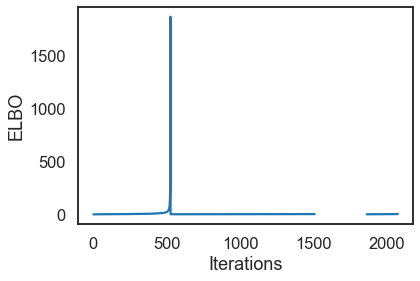

In [348]:
elbo = bints.elbo_track
elbo = elbo.detach().numpy()
f,ax=plt.subplots()
ax.set_ylabel('ELBO')

ax.set_xlabel('Iterations')
#ax.set_yscale('log')
ax.plot(elbo[0:
            ])


### Visualise training error between estimated params and true params

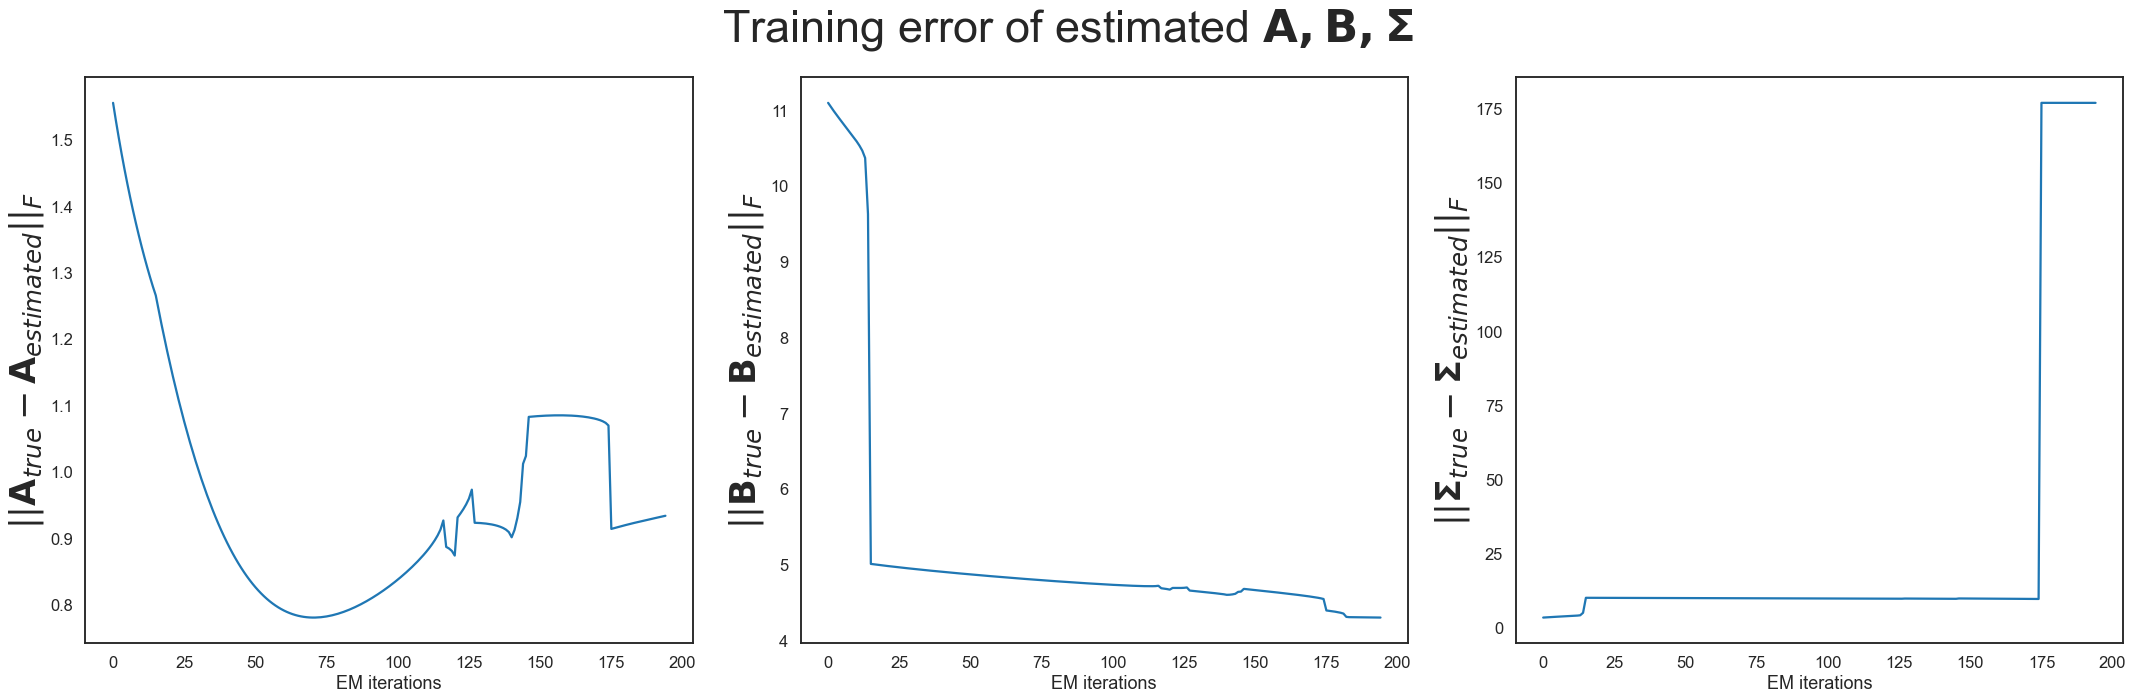

In [331]:
f,ax = plt.subplots(1,3,figsize=(30,10))

f.suptitle('Training error of estimated $\mathbf{A,B,\Sigma}$', fontsize=45)

ax[0].plot(bints.A_error_track[1:])
ax[0].set_ylabel('$||\mathbf{A}_{true}-\mathbf{A}_{estimated}||_F$',fontsize=35)
ax[1].plot(bints.B_error_track[1:])
ax[1].set_ylabel('$||\mathbf{B}_{true}-\mathbf{B}_{estimated}||_F$',fontsize=35)
ax[2].plot(bints.sigma_error_track[1:])
ax[2].set_ylabel('$||\mathbf{\Sigma}_{true}-\mathbf{\Sigma}_{estimated}||_F$',fontsize=35)

for i in [0,1,2]: 
    ax[i].set_xlabel('EM iterations')
plt.tight_layout()

### Visualisation evolution of coefficients of $\mathbf{A}$

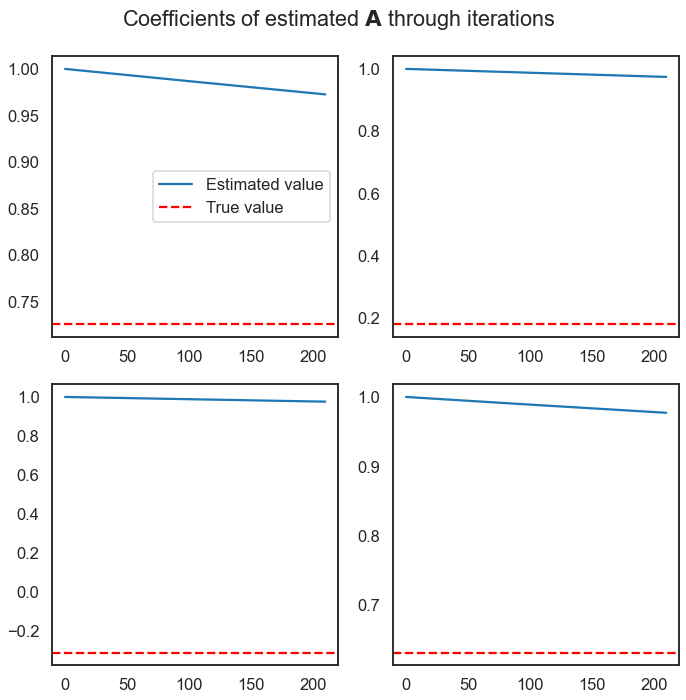

In [316]:
f,ax=plt.subplots(d,d,figsize=(10,10))
reshaped_A_track = bints.A_track.reshape(-1,d,d).detach().numpy()

f.suptitle('Coefficients of estimated $\mathbf{A}$ through iterations')


for i in np.arange(d): 
    for j in np.arange(d):
        ax[i,j].plot(reshaped_A_track[1:,i,j],label='Estimated value')
        
        ax[i,j].axhline(y = bints.true_A[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
        
        
plt.tight_layout()

### Visualisation evolution of coefficients of $\mathbf{B}$

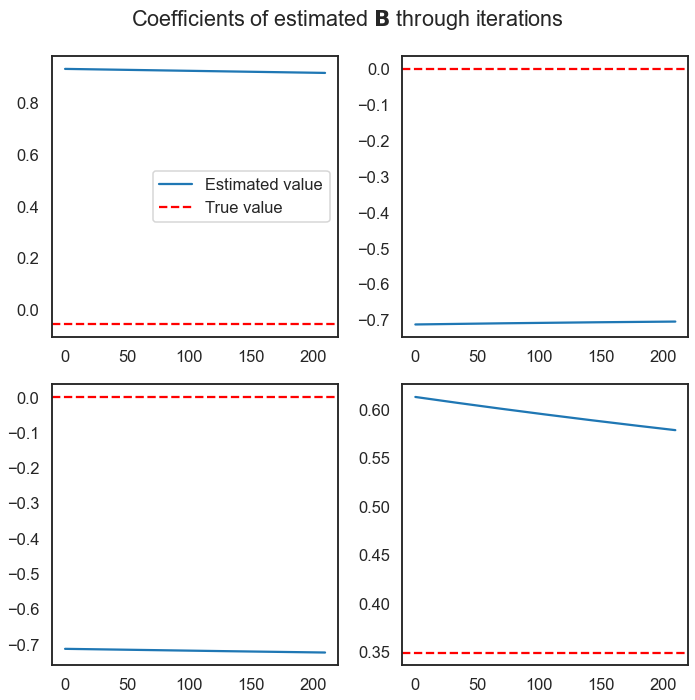

In [317]:
f,ax=plt.subplots(d,d,figsize=(10,10))
reshaped_B_track = bints.B_track.reshape(-1,d,d).detach().numpy()
f.suptitle('Coefficients of estimated $\mathbf{B}$ through iterations')


for i in np.arange(d): 
    for j in np.arange(d):
        ax[i,j].plot(reshaped_B_track[1:,i,j],label='Estimated value')
        ax[i,j].axhline(y = bints.true_B[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
plt.tight_layout()


### Visualisation evolution of coefficients of $\mathbf{\Sigma}$

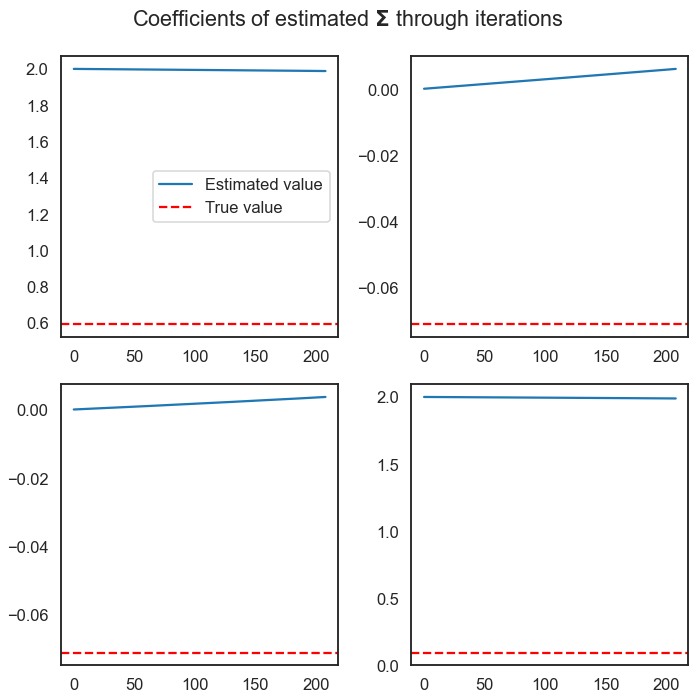

In [318]:
f,ax=plt.subplots(d,d,figsize=(10,10))
reshaped_sigma_track = bints.sigma_track.reshape(-1,d,d).detach().numpy()
f.suptitle('Coefficients of estimated $\mathbf{\Sigma}$ through iterations')

for i in np.arange(d): 
    
    for j in np.arange(d):
        ax[i,j].plot(reshaped_sigma_track[3:,i,j], label='Estimated value')
        
        ax[i,j].axhline(y = bints.true_sigma[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
plt.tight_layout()


### Visualisation evolution of mu_approx

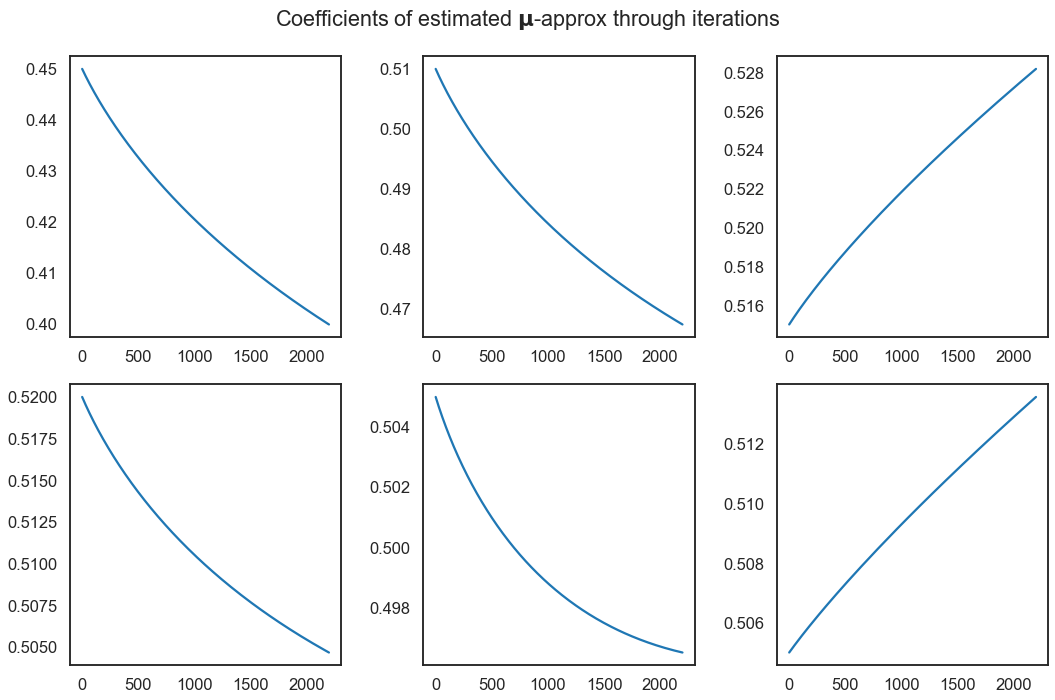

In [272]:
f,ax=plt.subplots(d,T+1,figsize=(15,10))
reshaped_mu_approx_track = bints.mu_approx_track.reshape(-1,d,T+1).detach().numpy()
f.suptitle('Coefficients of estimated $\mathbf{\mu}$-approx through iterations')

for i in np.arange(d): 
    for j in np.arange(T+1):
        ax[i,j].plot(reshaped_mu_approx_track[1:,i,j])
        
plt.tight_layout()

### Visualisation of estimated $\Lambda$-approx through iterations

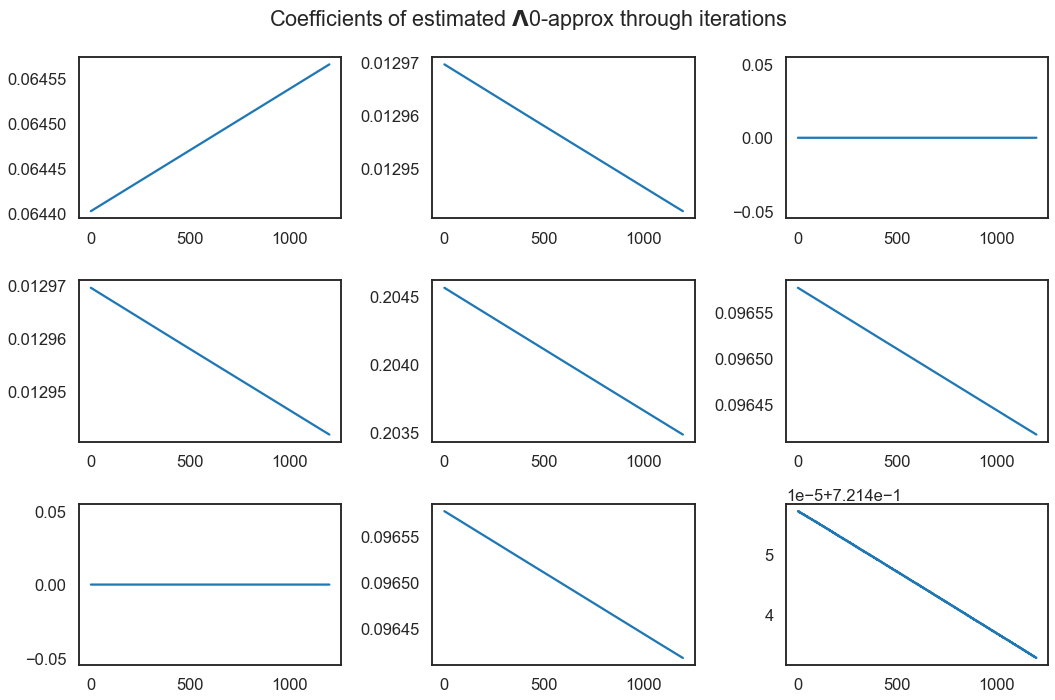

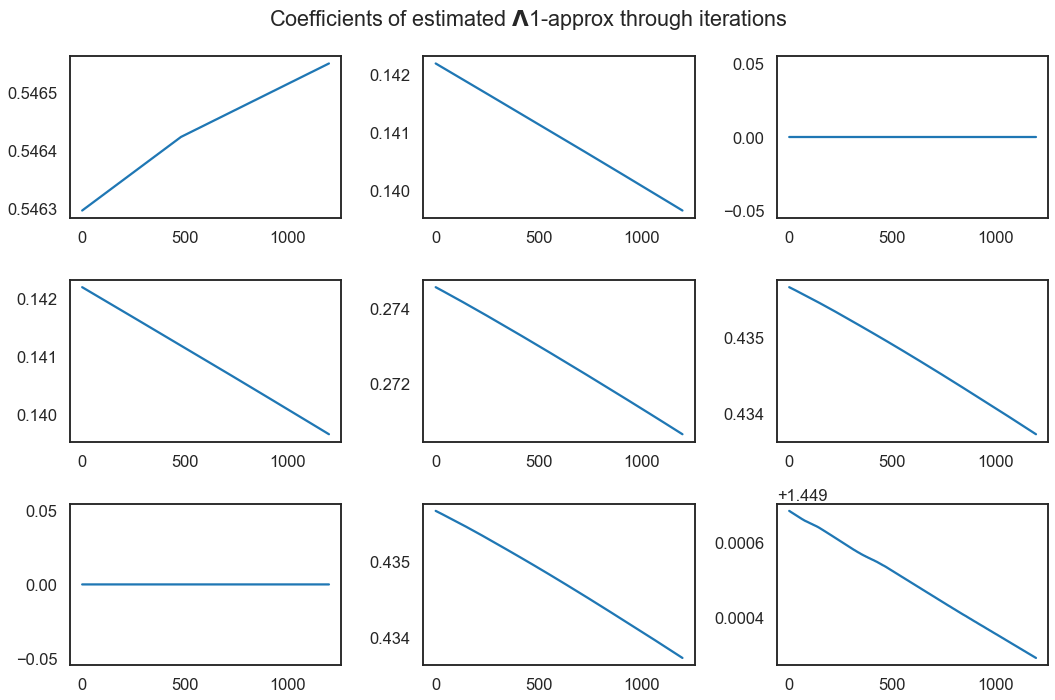

In [118]:
for k in np.arange(d):

    f,ax=plt.subplots(T+1,T+1,figsize=(15,10))
    reshaped_var_approx_track = bints.var_approx_track.reshape(-1,d,T+1,T+1)
    var_track = reshaped_var_approx_track[:,k,:,:]
    title= 'Coefficients of estimated $\mathbf{\Lambda}$'+ str(k) +'-approx through iterations'
    f.suptitle(title)

    for i in np.arange(T+1): 
        for j in np.arange(T+1):
            ax[i,j].plot(var_track[1:,i,j])

    plt.tight_layout()

### Visualisation of $\mathbf{\Omega}$-approx through iterations 

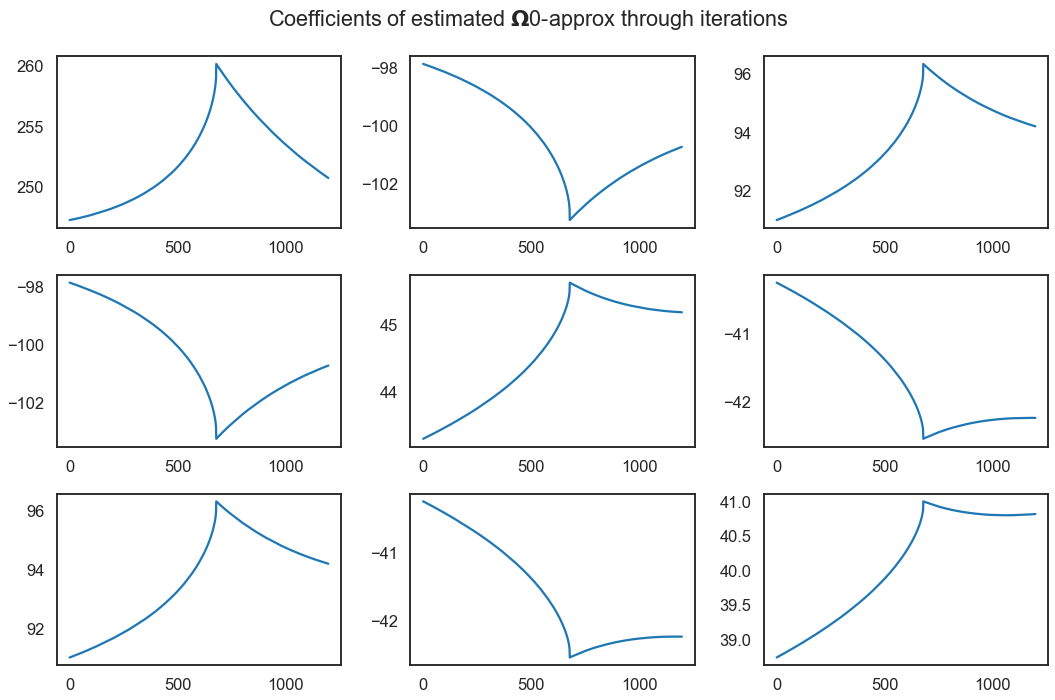

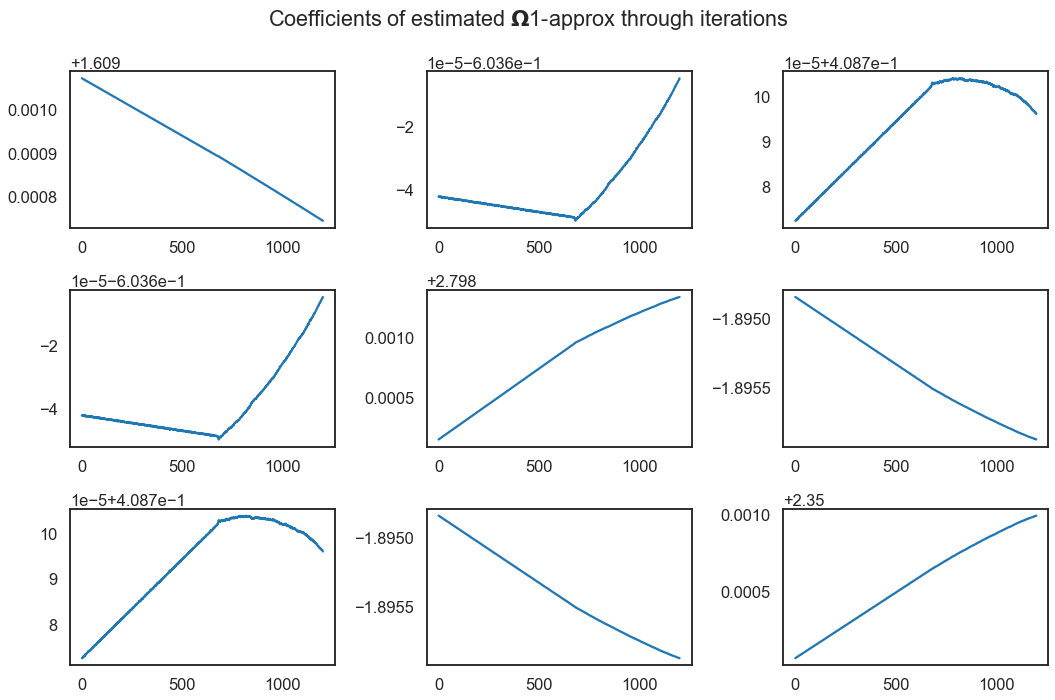

In [76]:
for k in np.arange(d):

    f,ax=plt.subplots(T+1,T+1,figsize=(15,10))
    reshaped_var_approx_track = bints.var_approx_track.reshape(-1,d,T+1,T+1)
    var_track = torch.linalg.inv(reshaped_var_approx_track[1:,k,:,:])
    inv_var_track = var_track
    title= 'Coefficients of estimated $\mathbf{\Omega}$'+ str(k) +'-approx through iterations'
    f.suptitle(title)

    for i in np.arange(T+1): 
        for j in np.arange(T+1):
            ax[i,j].plot(inv_var_track[1:,i,j])

    plt.tight_layout()

## Alternate optimization 

In [388]:
bints.optimize(max_iter=2200,lr1=1e-6,lr2=3e-2)

------ Iteration  0  ------   
V-step ELBO: tensor(-27.5007, grad_fn=<NegBackward0>)
EM-step ELBO: tensor(-28.3274, grad_fn=<NegBackward0>)
------ Iteration  1  ------   
V-step ELBO: tensor(-28.3042, grad_fn=<NegBackward0>)
EM-step ELBO: tensor(-28.9596, grad_fn=<NegBackward0>)
------ Iteration  2  ------   
V-step ELBO: tensor(-28.9199, grad_fn=<NegBackward0>)
EM-step ELBO: tensor(-29.8663, grad_fn=<NegBackward0>)
------ Iteration  3  ------   
V-step ELBO: tensor(-29.8812, grad_fn=<NegBackward0>)
EM-step ELBO: tensor(-30.7375, grad_fn=<NegBackward0>)
------ Iteration  4  ------   
V-step ELBO: tensor(-30.7654, grad_fn=<NegBackward0>)
EM-step ELBO: tensor(-31.5236, grad_fn=<NegBackward0>)
------ Iteration  5  ------   
V-step ELBO: tensor(-31.7853, grad_fn=<NegBackward0>)
EM-step ELBO: tensor(-32.5327, grad_fn=<NegBackward0>)
------ Iteration  6  ------   
V-step ELBO: tensor(-32.7721, grad_fn=<NegBackward0>)
EM-step ELBO: tensor(-33.7310, grad_fn=<NegBackward0>)
------ Iteration  7 

KeyboardInterrupt: 

### Visualize ELBO

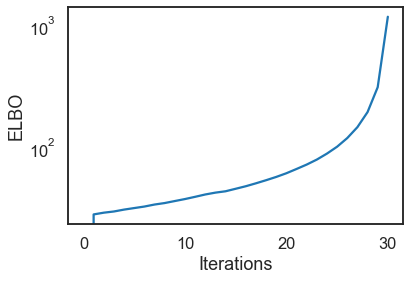

In [391]:
elbo = bints.elbo_track
elbo = elbo.detach().numpy()
f,ax=plt.subplots()
ax.set_ylabel('ELBO')

ax.set_xlabel('Iterations')
ax.set_yscale('log')
ax.plot(elbo[0:
            ])
